***RANDOM FOREST***

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/cleaned_variant_data_final.csv'
df = pd.read_csv(file_path, dtype={'Chromosome': str}, low_memory=False)
print(df.dtypes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Type                               object
Name                               object
GeneSymbol                         object
Origin                             object
Chromosome                         object
Start                               int64
ReviewStatus                       object
NumberSubmitters                    int64
Grouped_ClinicalSignificance       object
ReviewConfidence                  float64
is_frameshift                       int64
is_splice_site                      int64
is_missense                         int64
is_nonsense                         int64
is_synonymous                       int64
is_repeat_variant                   int64
type_Complex                         bool
type_Deletion                        bool
type_Duplication                     bool
type_Indel                           bool
type_Insertion                 

In [ ]:
df['Grouped_ClinicalSignificance'].value_counts()

,count
Grouped_ClinicalSignificance,
Uncertain significance,3226918
Likely benign,1738813
Benign,498134
Pathogenic,302815
Conflicting classification of pathogenicity,271029
Likely pathogenic,244478
Risk allele,46


In [ ]:
df = df[df['Grouped_ClinicalSignificance'] != 'Risk allele']


In [ ]:
X = df.drop('Grouped_ClinicalSignificance', axis=1)
y = df['Grouped_ClinicalSignificance']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Automatically detect and encode all object-type (categorical) columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Ensure conversion to string before encoding
    label_encoders[col] = le

# Encode the target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
class_names = le_target.classes_


In [ ]:
# Split the data with stratification to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [ ]:
# Initialize Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1  # Use all available cores for faster training
)

In [ ]:
# Measure training time
print("Training Random Forest model...")
start_training_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_training_time
print(f"Training time: {training_time:.4f} seconds")


Training Random Forest model...
Training time: 415.0413 seconds


In [ ]:
# Measure inference time
print("Making predictions...")
start_inference_time = time.time()
y_pred = rf_model.predict(X_test)
inference_time = time.time() - start_inference_time
print(f"Inference time: {inference_time:.4f} seconds")
print(f"Inference time per sample: {inference_time/len(y_test):.8f} seconds")

Making predictions...
Inference time: 27.2036 seconds
Inference time per sample: 0.00002165 seconds


In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Overall Metrics:
Accuracy: 0.8520
Precision: 0.7953
Recall: 0.7791
F1 Score: 0.7866


In [ ]:
# Get detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Detailed Classification Report:
                                             precision    recall  f1-score   support

                                     Benign       0.69      0.65      0.67     99627
Conflicting classification of pathogenicity       1.00      1.00      1.00     54206
                              Likely benign       0.82      0.83      0.82    347763
                          Likely pathogenic       0.58      0.51      0.54     48895
                                 Pathogenic       0.77      0.77      0.77     60563
                     Uncertain significance       0.90      0.92      0.91    645384

                                   accuracy                           0.85   1256438
                                  macro avg       0.80      0.78      0.79   1256438
                               weighted avg       0.85      0.85      0.85   1256438



In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)



Confusion Matrix:
[[ 64505      0  22680   1050    479  10913]
 [     0  54206      0      0      0      0]
 [ 18011      0 288289   2656    916  37891]
 [  1429      0   4914  24836   8340   9376]
 [   621      0   1722   6849  46819   4552]
 [  8381      0  33710   7236   4233 591824]]


In [ ]:
# Calculate TP, FP, TN, FN for each class
n_classes = len(class_names)
tp = np.zeros(n_classes)
fp = np.zeros(n_classes)
tn = np.zeros(n_classes)
fn = np.zeros(n_classes)

for i in range(n_classes):
    # True Positives
    tp[i] = cm[i, i]

    # False Positives (sum of column i excluding true positive)
    fp[i] = np.sum(cm[:, i]) - tp[i]

    # False Negatives (sum of row i excluding true positive)
    fn[i] = np.sum(cm[i, :]) - tp[i]

    # True Negatives (sum of all elements excluding elements in row i and column i, plus true positive)
    tn[i] = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])

# Print TP, FP, TN, FN for each class
print("\nPer-class Performance Metrics:")
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"  TP: {tp[i]:.0f}")
    print(f"  FP: {fp[i]:.0f}")
    print(f"  TN: {tn[i]:.0f}")
    print(f"  FN: {fn[i]:.0f}")
    print(f"  Precision: {tp[i] / (tp[i] + fp[i]):.4f}")
    print(f"  Recall: {tp[i] / (tp[i] + fn[i]):.4f}")
    print(f"  F1 Score: {2 * tp[i] / (2 * tp[i] + fp[i] + fn[i]):.4f}")



Per-class Performance Metrics:

Class: Benign
  TP: 64505
  FP: 28442
  TN: 1128369
  FN: 35122
  Precision: 0.6940
  Recall: 0.6475
  F1 Score: 0.6699

Class: Conflicting classification of pathogenicity
  TP: 54206
  FP: 0
  TN: 1202232
  FN: 0
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000

Class: Likely benign
  TP: 288289
  FP: 63026
  TN: 845649
  FN: 59474
  Precision: 0.8206
  Recall: 0.8290
  F1 Score: 0.8248

Class: Likely pathogenic
  TP: 24836
  FP: 17791
  TN: 1189752
  FN: 24059
  Precision: 0.5826
  Recall: 0.5079
  F1 Score: 0.5427

Class: Pathogenic
  TP: 46819
  FP: 13968
  TN: 1181907
  FN: 13744
  Precision: 0.7702
  Recall: 0.7731
  F1 Score: 0.7716

Class: Uncertain significance
  TP: 591824
  FP: 62732
  TN: 548322
  FN: 53560
  Precision: 0.9042
  Recall: 0.9170
  F1 Score: 0.9105


In [ ]:
# Normalize confusion matrix for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


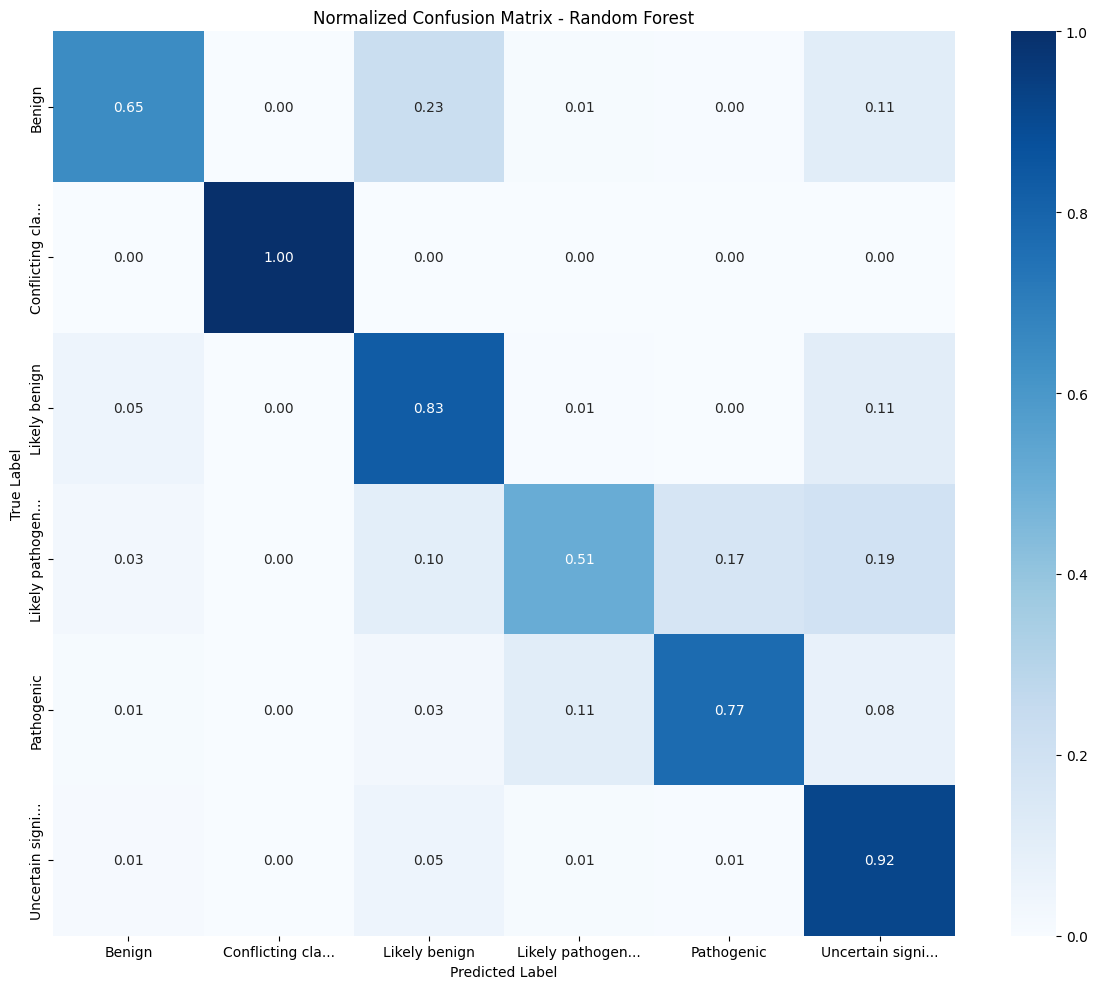

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[name[:15] + '...' if len(name) > 15 else name for name in class_names],
            yticklabels=[name[:15] + '...' if len(name) > 15 else name for name in class_names])
plt.title('Normalized Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('random_forest_confusion_matrix.png')
plt.show()

In [ ]:
# Convert predictions back to original class names for interpretation (optional)
y_test_original = le_target.inverse_transform(y_test)
y_pred_original = le_target.inverse_transform(y_pred)

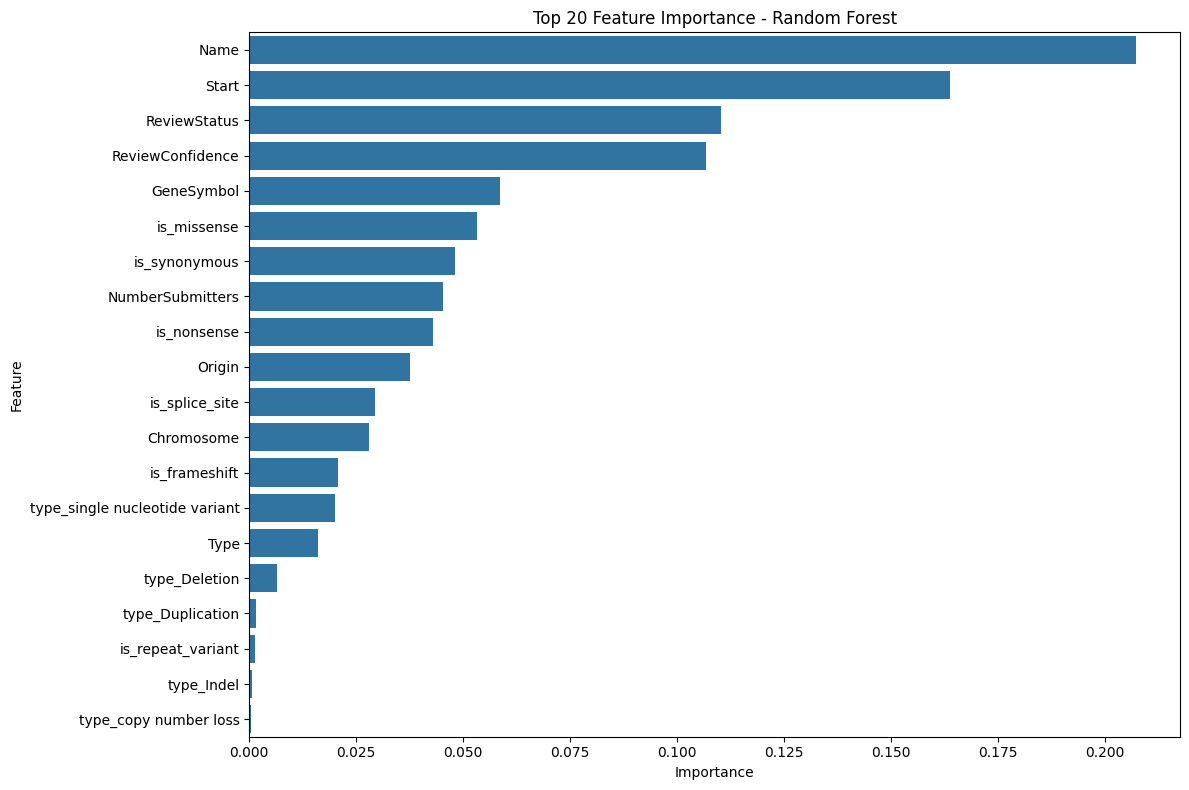

In [ ]:
# Plot feature importance
feature_importance = pd.DataFrame(
    {'Feature': X.columns, 'Importance': rf_model.feature_importances_}
)
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance - Random Forest')
plt.tight_layout()
plt.savefig('random_forest_feature_importance.png')
plt.show()

In [ ]:
# Summary of model performance
print("\nRandom Forest Model Performance Summary:")
print(f"Total samples: {len(y_test)}")
print(f"Training time: {training_time:.4f} seconds")
print(f"Inference time: {inference_time:.4f} seconds")
print(f"Inference time per sample: {inference_time/len(y_test):.8f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")


Random Forest Model Performance Summary:
Total samples: 1256438
Training time: 415.0413 seconds
Inference time: 27.2036 seconds
Inference time per sample: 0.00002165 seconds
Accuracy: 0.8520
Precision (macro): 0.7953
Recall (macro): 0.7791
F1 Score (macro): 0.7866
